In [3]:
import eddington_fd as eddington

import netCDF4 as nc

with nc.Dataset('rte_CoSSIR_15Jan2023.nc') as f:
    kext=f.variables['kext'][:]
    scat=f.variables['scat'][:]
    asym=f.variables['asym'][:]
    temp=f.variables['temp'][:]
    tb=f.variables['tb'][:]

In [4]:
dir(eddington)
i0=0
dz=0.25
import numpy as np
tbL=[]
for i0 in range(1000):
    kext1=kext[i0,:].copy()
    scat1=scat[i0,:].copy()
    asym1=asym[i0,:].copy()
    temp1=temp[i0,:].copy()
    temp_mid=(temp1[:-1]+temp1[1:])/2
    eps=0.7
    A,B=eddington.seteddington1d(kext1,scat1,asym1,temp_mid,eps,dz,temp1[0])
    I01p=np.linalg.solve(A,B)
    #print([A[0:10,0:10]])
    incAng=53.0
    Tb=eddington.tbf90(I01p,temp_mid,incAng,kext1,scat1,asym1,eps,dz)
    #print(Tb)
    tbL.append(Tb)

In [64]:
import numpy as np

def tbf90_numpy(I01p, T, incAng, k, a, g, n, eps, dz):
    pi = 3.1415
    cos1 = np.cos(incAng / 180.0 * pi)
    
    Jup = np.zeros(n + 1)
    Jd = np.zeros(n + 1)
    
    for k1 in range(n + 1):
        Jup[k1] = (1 - a[k1]) * T[k1] + a[k1] * (0.5 * (I01p[2*k1] + I01p[2*k1 + 2]) * g[k1] * cos1 + I01p[2*k1+1])
        Jd[k1] = (1 - a[k1]) * T[k1] + a[k1] * (-0.5 * (I01p[2*k1] + I01p[2*k1 + 2]) * g[k1] * cos1 + I01p[2*k1+1])
    
    intDo = np.zeros(n + 1)
    intUp = np.zeros(n + 1)
    
    intDo[0] = k[0] * dz / 2
    intUp[n] = k[n] * dz / 2
    
    for k1 in range(1, n+1):
        intUp[n - k1] = intUp[n - k1 + 1] + 0.5 * (k[n - k1] + k[n - k1 + 1]) * dz
    
    for k1 in range(1, n + 1):
        intDo[k1] = intDo[k1 - 1] + 0.5 * (k[k1] + k[k1 - 1]) * dz
    
    sumJD = 0.0
    sumJU = 0.0
    
    for i in range(n + 1):
        sumJD += Jd[i] * np.exp(-intDo[i] / cos1) * k[i] * dz / cos1
        sumJU += Jup[i] * np.exp(-intUp[i] / cos1) * k[i] * dz / cos1
    
    Tb = (1 - eps) * np.exp(-intUp[0] / cos1) * sumJD + sumJU + eps * np.exp(-intUp[0] / cos1) * T[0]
    return Tb

def SetEddington1D_numpy(k, a, g, T, n, eps, dz, Ts):
    Abig=np.zeros((2*n+3,2*n+3),float)
    B=np.zeros((2*n+3),float)
    
    for i in range(n + 1):
        Abig[2*i + 1, 2*i + 1] = 3 * k[i] * (1 - a[i]) * dz
        Abig[2*i + 1, 2*i + 2] = 1
        Abig[2*i + 1, 2*i] = -1
        B[2*i + 1] = 3 * k[i] * (1 - a[i]) * T[i] * dz
        
        if 2*i + 2 < 2*n + 3-2:
            #print(i,k.shape)
            km = 0.5 * (k[i] + k[i + 1])
            am = 0.5 * (a[i] + a[i + 1])
            gm = 0.5 * (g[i] + g[i + 1])
            Abig[2*i + 2, 2*i + 2] = km * (1 - am * gm) * dz
            Abig[2*i + 2, 2*i + 3] = 1
            Abig[2*i + 2, 2*i + 1] = -1
            B[2*i + 2] = 0.0
    
    Abig[2*n + 2, 2*n + 1] = 1.0
    Abig[2*n + 2, 2*n + 2] = -1.0 / 3
    Abig[2*n + 2, 2*n] = -1.0 / 3
    B[2*n + 2] = 2.7
    
    Abig[0, 0] = (2 - eps) / (3 * eps)
    Abig[0, 1] = 1.0
    Abig[0, 2] = (2 - eps) / (3 * eps)
    B[0] = Ts
    return Abig, B

def tbwrapper_numpy(kext1, scat1, asym1, temp_mid, dz, eps,n, incAng):
    Abig_py, B_py = SetEddington1D_numpy(kext1, scat1, asym1, temp_mid, n, eps, dz, temp_mid[0])
    I01p_py = np.linalg.solve(Abig_py, B_py)
    Tb_py = tbf90_numpy(I01p_py, temp_mid, incAng, kext1, scat1, asym1, n, eps, dz)
    return Tb_py

In [37]:
Tb_pyL=[]
for i0 in range(1000):
    kext1=kext[i0,:].copy()
    scat1=scat[i0,:].copy()
    asym1=asym[i0,:].copy()
    temp1=temp[i0,:].copy()
    temp_mid=(temp1[:-1]+temp1[1:])/2
    eps=0.7
    Abig_py, B_py = SetEddington1D(kext1, scat1, asym1, temp_mid, 79, 0.7, 0.25, temp1[0])
    I01p_py = np.linalg.solve(Abig_py, B_py)
    Tb_py = tbf90_py(I01p_py, temp_mid, 53.0, kext1, scat1, asym1, 79, 0.7, 0.25)
    Tb_pyL.append(Tb_py)
#print(np.isclose(A, Abig_py).all())
#print(np.isclose(B, B_py).all())
#print(np.isclose(I01p, I01p_py).all())
import matplotlib.pyplot as plt
#plt.scatter(B,B_py)
#plt.scatter(A.flatten(),Abig_py.flatten())
#plt.scatter(I01p,I01p_py)
print(Tb_py, Tb)

247.80090273711838 247.80091857910156


In [39]:
print(np.corrcoef(tbL,Tb_pyL))

[[1. 1.]
 [1. 1.]]


In [59]:
import torch
from math import cos

#@torch.jit.script
def tbf90_py(I01p, T, incAng, k, a, g, n, eps, dz):
    pi = 3.1415
    cos1 = cos(incAng / 180.0 * pi)
    
    Jup = torch.zeros(n + 1)
    Jd = torch.zeros(n + 1)
    
    for k1 in range(n + 1):
        Jup[k1] = (1 - a[k1]) * T[k1] + a[k1] * (0.5 * (I01p[2*k1] + I01p[2*k1 + 2]) * g[k1] * cos1 + I01p[2*k1 + 1])
        Jd[k1] = (1 - a[k1]) * T[k1] + a[k1] * (-0.5 * (I01p[2*k1] + I01p[2*k1 + 2]) * g[k1] * cos1 + I01p[2*k1 + 1])
    
    intDo = torch.zeros(n + 1)
    intUp = torch.zeros(n + 1)
    
    intDo[0] = k[0] * dz / 2
    intUp[n] = k[n] * dz / 2
    
    for k1 in range(1, n + 1):
        intUp[n - k1] = intUp[n - k1 + 1] + 0.5 * (k[n - k1] + k[n - k1 + 1]) * dz
    
    for k1 in range(1, n + 1):
        intDo[k1] = intDo[k1 - 1] + 0.5 * (k[k1] + k[k1 - 1]) * dz
    
    sumJD = torch.tensor(0.0)
    sumJU = torch.tensor(0.0)
    
    for i in range(n + 1):
        sumJD += Jd[i] * torch.exp(-intDo[i] / cos1) * k[i] * dz / cos1
        sumJU += Jup[i] * torch.exp(-intUp[i] / cos1) * k[i] * dz / cos1
    
    Tb = (1 - eps) * torch.exp(-intUp[0] / cos1) * sumJD + sumJU + eps * torch.exp(-intUp[0] / cos1) * T[0]
    return Tb

#@torch.jit.script
def SetEddington1D(k, a, g, T, n, eps, dz, Ts):
    Abig = torch.zeros((2*n+3, 2*n+3), dtype=torch.float32)
    B = torch.zeros(2*n+3, dtype=torch.float32)
    
    for i in range(n + 1):
        Abig[2*i + 1, 2*i + 1] = 3 * k[i] * (1 - a[i]) * dz
        Abig[2*i + 1, 2*i + 2] = 1
        Abig[2*i + 1, 2*i] = -1
        B[2*i + 1] = 3 * k[i] * (1 - a[i]) * T[i] * dz
        
        if 2*i + 2 < 2*n + 3 - 2:
            km = 0.5 * (k[i] + k[i + 1])
            am = 0.5 * (a[i] + a[i + 1])
            gm = 0.5 * (g[i] + g[i + 1])
            Abig[2*i + 2, 2*i + 2] = km * (1 - am * gm) * dz
            Abig[2*i + 2, 2*i + 3] = 1
            Abig[2*i + 2, 2*i + 1] = -1
            B[2*i + 2] = 0.0
    
    Abig[2*n + 2, 2*n + 1] = 1.0
    Abig[2*n + 2, 2*n + 2] = -1.0 / 3
    Abig[2*n + 2, 2*n] = -1.0 / 3
    B[2*n + 2] = 2.7
    
    Abig[0, 0] = (2 - eps) / (3 * eps)
    Abig[0, 1] = 1.0
    Abig[0, 2] = (2 - eps) / (3 * eps)
    B[0] = Ts
    return Abig, B

def tbwrapper(kext1, scat1, asym1, temp_mid, dz, eps, n, incAng):
    #temp_mid = temp1[1:-1]
    Abig_py, B_py = SetEddington1D(kext1, scat1, asym1, temp_mid, n, eps, dz, temp_mid[0])
    I01p_py = torch.linalg.solve(Abig_py, B_py)
    Tb_py = tbf90_py(I01p_py, temp_mid, incAng, kext1, scat1, asym1, n, eps, dz)
    return Tb_py


In [63]:

# Example usage:
# Define your input tensors with requires_grad=True if you want to calculate gradients with respect to them
for i in range(1000):
    kext1 = kext[i,:].copy()
    scat1 = scat[i,:].copy()
    asym1 = asym[i,:].copy()
    temp1 = temp[i,:].copy()
    temp_mid = (temp1[:-1] + temp1[1:]) / 2
    kext1_torch = torch.tensor(kext1, dtype=torch.float32, requires_grad=True)
    scat1_torch = torch.tensor(scat1, dtype=torch.float32, requires_grad=True)
    asym1_torch = torch.tensor(asym1, dtype=torch.float32, requires_grad=True)
    temp_mid_torch = torch.tensor(temp_mid, dtype=torch.float32, requires_grad=True)

# dz, eps, n, and incAng can remain as Python variables
    dz = 0.25  # example value
    eps = torch.tensor(0.75, dtype=torch.float32, requires_grad=True)  # example value
    n = 79    # example value
    incAng = 53.0  # example value

# Calculate Tb
    Tb_torch = tbwrapper(kext1_torch, scat1_torch, asym1_torch, temp_mid_torch, dz, eps, n, incAng)


# If you want to calculate gradients with respect to kext1, scat1, asym1, or temp1
    #Tb_torch.backward()


In [65]:
for i in range(1000):
    kext1 = kext[i,:].copy()
    scat1 = scat[i,:].copy()
    asym1 = asym[i,:].copy()
    temp1 = temp[i,:].copy()
    temp_mid = (temp1[:-1] + temp1[1:]) / 2
    tb_numpy=tbwrapper_numpy(kext1, scat1, asym1, temp_mid, 0.25, 0.7, 79, 53.0)

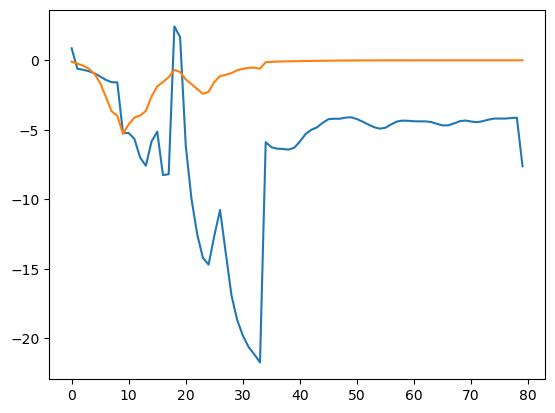

In [61]:
plt.plot(kext1_torch.grad)
plt.plot(scat1_torch.grad)

[[1.         0.99944752]
 [0.99944752 1.        ]]


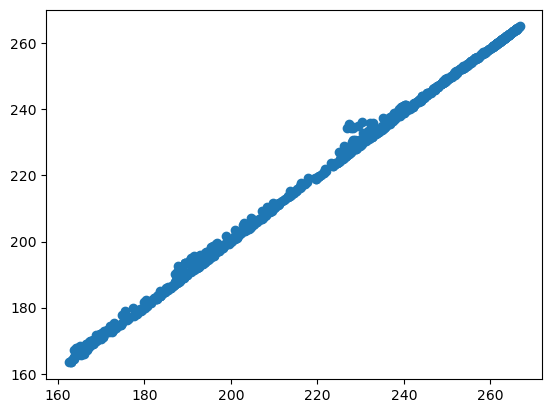

In [5]:
import matplotlib.pyplot as plt
#plt.plot(kext1)
plt.scatter(tbL,tb[:1000])
print(np.corrcoef(tbL,tb[:1000]))
#print(B)